# Data Cleaning

<br>

__Technical Notebook -__  Module 1 Microsoft Project <br />
__Data Scientists -__  Nathan Venos, Max Tingle <br />
__Flatiron School -__ DC Data Science Fellowship

<br>


### Importing Libraries

In [31]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string

### Reading Selected IMDB CSV Data Files

In [3]:
# read csv files
#imdb_name_basics = pd.read_csv('../Data/imdb.name.basics.csv.gz')
#imdb_title_akas = pd.read_csv('../Data/imdb.title.akas.csv.gz')
imdb_title_basics = pd.read_csv('../Data/imdb.title.basics.csv.gz')
imdb_title_crew = pd.read_csv('../Data/imdb.title.crew.csv.gz')
#imdb_title_principals = pd.read_csv('../Data/imdb.title.principals.csv.gz')
imdb_title_ratings = pd.read_csv('../Data/imdb.title.ratings.csv.gz')

### Cleaning IMDB DataFrames & Setting Indices to Prepare for Join

In [4]:
#re-name column in title_akas
#imdb_title_akas = imdb_title_akas.rename(columns={'title_id': 'tconst'})

In [5]:
# setting index columns
#imdb_title_akas.set_index("tconst", inplace=True)
imdb_title_basics.set_index("tconst", inplace=True)
imdb_title_crew.set_index("tconst", inplace=True)
#imdb_title_principals.set_index("tconst", inplace=True)
imdb_title_ratings.set_index("tconst", inplace=True)

In [6]:
# replacing empty genre cells in imdb_title_basics with "Missing"
imdb_title_basics['genres'].replace(np.nan, 'Missing', inplace=True, regex=True)

In [7]:
# lowercase column names
imdb_title_ratings.rename(
    columns={'averagerating': 'average_rating', 'numvotes': 'num_votes'}, inplace=True)

### Joining DataFrames

In [8]:
# creating imbd dataframe1
imdb_df1 = imdb_title_basics

In [9]:
# joining imbd_title_ratings to imbd_df
imdb_df2 = imdb_df1.join(imdb_title_ratings, how='left')

In [10]:
# joining imbd_title_crew to imbd_df
imdb_df3 = imdb_df2.join(imdb_title_crew, how='left')

### Reading Selected Budget and Revenue CSV Data Files

In [33]:
# We use the bom.movie_gross.csv data to identify each movie's studio.
# We wanted to know the studio so we can identify trends within individual studios
bom = pd.read_csv('../Data/bom.movie_gross.csv')

# We use the tn.movie_budgets.csv to identify each movie's budget and revenue figures.
tn = pd.read_csv('../Data/tn.movie_budgets.csv')

### Initial Cleaning of Budget and Revenue DataFrames

In [35]:
# cleaning up an encoding issue for apostrophes
tn.movie = tn.movie.apply(lambda x: x.replace('â\x80\x99', "'"))

# Converting the money columns, which have values stored as strings due to dollar-signs and commas, to numbers.


def convert_currency_str_to_num(dataframe, column):
    dataframe[column] = dataframe[column].apply(lambda x: x.replace('$', ''))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(',', ''))
    dataframe[column] = dataframe[column].astype('float')


convert_currency_str_to_num(tn, 'production_budget')
convert_currency_str_to_num(tn, 'domestic_gross')
convert_currency_str_to_num(tn, 'worldwide_gross')

In [36]:
# Removing movies from before 2010 to conform with the time period in the other datasets
tn['year'] = tn.release_date.apply(lambda x: int(x[-4:]))
tn = tn.loc[tn.year >= 2010]

In [37]:
# Converting the release_date to a datetime object
tn['release_date'] = pd.to_datetime(tn.release_date)

In [38]:
# tn.head()

In [39]:
# bom.head()

In [40]:
# This function returns True if the movie title has a 4-digit number/year within a parenthetical
# We found some titles in this dataset which had the year appended in a parenthetical,
# but that wasn't the case in the other datasets,
# so they would get excluded from an inner join on the titles.


def parenthetical_is_a_year(words):
    if words.find("(") != -1:
        new_words = words[(words.find("(")+1):(words.find(")"))]
        if (new_words.isdigit()) and (len(new_words) == 4):
            return True
        else:
            return False
    else:
        return False

In [41]:
# This function relies on parenthetical_is_a_year() to determine if there's a year appended to the title,
# and then removes the appended year if it exists


def remove_appended_yr_from_title(dataframe, column):
    dataframe[column] = dataframe[column].apply(
        lambda x: x[:(x.find("(")-1)] if parenthetical_is_a_year(x) else x)

In [42]:
remove_appended_yr_from_title(bom, 'title')
# bom.head()

In [43]:
# This function removes punctuation from the titles and makes all characters lowercase.
# The intent is to remove styling that could inhibit a match when joining different datasets


def title_string_format_standardization(dataframe, column):
    dataframe[column] = dataframe[column].apply(lambda x: str(x).translate(str.maketrans('',
                                                                                         '',
                                                                                         string.punctuation)
                                                                           ).lower())

In [44]:
title_string_format_standardization(tn, 'movie')
title_string_format_standardization(bom, 'title')

In [45]:
# tn.head()

In [46]:
# bom.head()

In [47]:
# bom.info()

In [48]:
# tn.info()

In [49]:
# Creating uniquely named year columns for comparison after joining the dataframes
bom.rename(columns={'year': 'bom_year'}, inplace=True)
tn.rename(columns={'year': 'tn_year'}, inplace=True)

In [50]:
print(bom.columns)
print(tn.columns)

# Only keeping pertinent columns of each dataframe.
bom = bom[['title', 'studio', 'bom_year']].copy()
tn = tn[['movie', 'release_date', 'production_budget', 'domestic_gross',
         'worldwide_gross', 'tn_year']].copy()

# Dropping the 5 rows from bom that have nulls since the count is so low
bom.dropna(inplace=True)

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'bom_year'], dtype='object')
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'tn_year'],
      dtype='object')


In [51]:
# Creating a foreign_gross column.
tn['foreign_gross'] = tn['worldwide_gross'] - tn['domestic_gross']
# tn.head()

In [52]:
# Inner joining the studio and budget+revenue data sets to ensure we have a set of movies with a complete set of info.
studio_movie_performance_inner = bom.merge(right=tn,
                                           how='inner',
                                           left_on='title',
                                           right_on='movie')

In [53]:
# studio_movie_performance_inner.info()

In [54]:
# Investigating potential duplicate records where the years don't match
studio_movie_performance_inner.loc[studio_movie_performance_inner.bom_year 
                                   != studio_movie_performance_inner.tn_year]

title  studio  bom_year  \
17                         robin hood    Uni.      2010   
18                         robin hood    LG/S      2018   
44                        unstoppable   WGUSA      2018   
61    the girl with the dragon tattoo    MBox      2010   
115                         leap year  Strand      2011   
134                            mother   Magn.      2010   
173                            frozen   Anch.      2010   
201             the girl on the train  Strand      2010   
268                     the iron lady   Wein.      2011   
357       we need to talk about kevin   Osci.      2011   
362                        like crazy  Strand      2017   
385                   the other woman     IFC      2011   
394                     beautiful boy   Anch.      2011   
400                        blood ties     ALP      2011   
531                    the apparition    MBox      2018   
534                       on the road     IFC      2012   
535                     promised land   Focus      2012   
539                      albert nobbs   RAtt.      2012   
659                               her      WB      2013   
667                            snitch    LG/S      2013   
683                            trance    FoxS      2013   
708                           believe     ORF      2013   
717                          the wall    MBox      2013   
804                             selma    Par.      2014   
860                             mommy   RAtt.      2014   
870                           highway     UTV      2014   
981               the lady in the van     SPC      2015   
1026                            youth      CL      2017   
1034                          phantom     UTV      2015   
1038                             eden      BG      2015   
1139                  a monster calls   Focus      2016   
1166                       regression  W/Dim.      2016   
1333                       the square   Magn.      2017   
1334                       the square   Magn.      2017   

                                movie release_date  production_budget  \
17                         robin hood   2018-11-21         99000000.0   
18                         robin hood   2010-05-14        210000000.0   
44                        unstoppable   2010-11-12         95000000.0   
61    the girl with the dragon tattoo   2011-12-20         90000000.0   
115                         leap year   2010-01-08         19000000.0   
134                            mother   2017-09-15         30000000.0   
173                            frozen   2013-11-22        150000000.0   
201             the girl on the train   2016-10-07         45000000.0   
268                     the iron lady   2012-01-13         14000000.0   
357       we need to talk about kevin   2012-01-13          7000000.0   
362                        like crazy   2011-10-28           250000.0   
385                   the other woman   2014-04-25         40000000.0   
394                     beautiful boy   2018-10-12         25000000.0   
400                        blood ties   2014-03-21         26000000.0   
531                    the apparition   2012-08-24         17000000.0   
534                       on the road   2013-03-22         25000000.0   
535                     promised land   2013-01-04         15000000.0   
539                      albert nobbs   2011-12-21          7500000.0   
659                               her   2014-01-10         23000000.0   
667                            snitch   2012-12-31           850000.0   
683                            trance   2012-12-31           950000.0   
708                           believe   2016-12-02          3500000.0   
717                          the wall   2017-05-12          3000000.0   
804                             selma   2015-01-09         20000000.0   
860                             mommy   2015-01-23          4900000.0   
870                           highway   2012-12-31          2000000.

In [55]:
# The nature of the inner join created some unwanted records
studio_movie_performance_inner.loc[studio_movie_performance_inner.title == 'robin hood']

title studio  bom_year       movie release_date  production_budget  \
16  robin hood   Uni.      2010  robin hood   2010-05-14        210000000.0   
17  robin hood   Uni.      2010  robin hood   2018-11-21         99000000.0   
18  robin hood   LG/S      2018  robin hood   2010-05-14        210000000.0   
19  robin hood   LG/S      2018  robin hood   2018-11-21         99000000.0   

    domestic_gross  worldwide_gross  tn_year  foreign_gross  
16     105487148.0      322459006.0     2010    216971858.0  
17      30824628.0       84747441.0     2018     53922813.0  
18     105487148.0      322459006.0     2010    216971858.0  
19      30824628.0       84747441.0     2018     53922813.0

In [56]:
# Removing the mismatched data based on the years
studio_movie_performance_inner = studio_movie_performance_inner.loc[studio_movie_performance_inner.bom_year
                                                                    == studio_movie_performance_inner.tn_year].copy()

In [57]:
imdb_titles = imdb_df3.reset_index()

In [60]:
# imdb_titles.head()

tconst                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  average_rating  \
0        2013            175.0    Action,Crime,Drama             7.0   
1        2019            114.0       Biography,Drama             7.2   
2        2018            122.0                 Drama             6.9   
3        2018              NaN          Comedy,Drama             6.1   
4        2017             80.0  Comedy,Drama,Fantasy             6.5   

   num_votes            directors                                  writers  
0       77.0            nm0712540  nm0023551,nm1194313,nm0347899,nm1391276  
1       43.0            nm0002411                                      NaN  
2     4517.0            nm0000080                      nm0000080,nm0462648  
3       13.0            nm0611531                                nm0347899  
4      119.0  nm0765384,nm0749914                      nm1360635,nm0749914

In [61]:
# Creating subsets of the dataframe with the unique IMDb title ID (i.e. tconst).
# These are then concatenated and duplicates are removed.
# This provides a map between all potential IMDb titles and their unique IDs.
primary_titles = imdb_titles[['tconst', 'primary_title', 'start_year', 'num_votes']].copy()
original_titles = imdb_titles[['tconst', 'original_title', 'start_year', 'num_votes']].copy()
primary_titles.columns = ['tconst', 'title', 'imdb_year', 'num_votes']
original_titles.columns = ['tconst', 'title', 'imdb_year', 'num_votes']

In [62]:
imdb_titles_only = pd.concat([primary_titles, original_titles])

In [63]:
# Standardizing the title formats
title_string_format_standardization(imdb_titles_only, 'title')

In [64]:
# Removing duplicates.
imdb_titles_only = imdb_titles_only.loc[imdb_titles_only.duplicated() == False]
imdb_titles_only.dropna(inplace=True)

In [65]:
imdb_titles_only.reset_index(inplace=True)
imdb_titles_only.drop('index', axis=1, inplace=True)
# imdb_titles_only.head()

In [66]:
# Joining the unique IMDb title ID (i.e. tconst) with the budget, revenue and studio data.
studio_movie_performance_inner_w_imdb = studio_movie_performance_inner.merge(right=imdb_titles_only,
                                                                             how='inner',
                                                                             left_on='title',
                                                                             right_on='title')

In [67]:
# studio_movie_performance_inner_w_imdb.info()

In [68]:
# studio_movie_performance_inner_w_imdb.head()

In [69]:
# Tracking down duplicates, shortening df name to make this code shorter.
smpiwi = studio_movie_performance_inner_w_imdb.copy()
smpiwi['duplicates'] = smpiwi.title.apply(lambda x:
                                          len(smpiwi.title.loc[smpiwi.title == x]))

In [70]:
# Lots of duplicates that will need to be addressed
len(smpiwi.loc[smpiwi.duplicates > 1])

548

In [71]:
# Only retaining records where the year in the Budget and Revenue data matches IMDb
smpiwi = smpiwi.loc[smpiwi.bom_year == smpiwi.imdb_year]

In [72]:
# Recreating the duplicate count after trimming the dataset
smpiwi['duplicates'] = smpiwi.title.apply(lambda x:
                                          len(smpiwi.title.loc[smpiwi.title == x]))

In [73]:
# Reviewing the remaining duplicates to identify trends.
# There is generally a significant difference in the number of votes between duplicate movies
# We assumed the movie with more votes is likely the one for which budget data is available
smpiwi.loc[smpiwi.duplicates > 1].head(20)

title studio  bom_year                movie release_date  \
1    alice in wonderland     BV      2010  alice in wonderland   2010-03-05   
2    alice in wonderland     BV      2010  alice in wonderland   2010-03-05   
17            robin hood   Uni.      2010           robin hood   2010-05-14   
23            robin hood   LG/S      2018           robin hood   2018-11-21   
24            robin hood   LG/S      2018           robin hood   2018-11-21   
62     the bounty hunter   Sony      2010    the bounty hunter   2010-03-19   
63     the bounty hunter   Sony      2010    the bounty hunter   2010-03-19   
80             burlesque   SGem      2010            burlesque   2010-11-24   
81             burlesque   SGem      2010            burlesque   2010-11-24   
128            leap year   Uni.      2010            leap year   2010-01-08   
129            leap year   Uni.      2010            leap year   2010-01-08   
163                cyrus   FoxS      2010                cyrus   2010-06-18   
164                cyrus   FoxS      2010                cyrus   2010-06-18   
203          the tempest  Mira.      2010          the tempest   2010-12-10   
204          the tempest  Mira.      2010          the tempest   2010-12-10   
268           the artist  Wein.      2011           the artist   2011-11-25   
269           the artist  Wein.      2011           the artist   2011-11-25   
292            abduction    LGF      2011            abduction   2011-09-23   
293            abduction    LGF      2011            abduction   2011-09-23   
394        a better life   Sum.      2011        a better life   2011-06-24   

     production_budget  domestic_gross  worldwide_gross  tn_year  \
1          200000000.0     334191110.0     1.025491e+09     2010   
2          200000000.0     334191110.0     1.025491e+09     2010   
17         210000000.0     105487148.0     3.224590e+08     2010   
23          99000000.0      30824628.0     8.474744e+07     2018   
24          99000000.0      30824628.0     8.474744e+07     2018   
62          45000000.0      67061228.0     1.358088e+08     2010   
63          45000000.0      67061228.0     1.358088e+08     2010   
80          55000000.0      39440655.0     9.055268e+07     2010   
81          55000000.0      39440655.0     9.055268e+07     2010   
128         19000000.0      25918920.0     3.261892e+07     2010   
129         19000000.0      25918920.0     3.261892e+07     2010   
163          7000000.0       7468936.0     1.006290e+07     2010   
164          7000000.0       7468936.0     1.006290e+07     2010   
203         20000000.0        277943.0     2.779430e+05     2010   
204         20000000.0        277943.0     2.779430e+05     2010   
268         16000000.0      44667095.0     1.282567e+08     2011   
269         16000000.0      44667095.0     1.282567e+08     2011   
292         35000000.0      28087155.0     8.664836e+07     2011   
293         35000000.0      28087155.0     8.664836e+07     2011   
394         10000000.0       1759252.0     1.884251e+06     2011   

     foreign_gross     tconst  imdb_year  num_votes  duplicates  
1      691300000.0  tt1014759       2010   358813.0           2  
2      691300000.0  tt2049386       2010        6.0           2  
17     216971858.0  tt0955308       2010   239480.0           3  
23      53922813.0  tt4532826       2018    41588.0           3  
24      53922813.0  tt6858500       2018        5.0           3  
62      68747609.0  tt1038919       2010   112444.0           2  
63      68747609.0  tt1472211       2010       29.0           2  
80      51112020.0  tt1126591       2010    71021.0           2  
81      51112020.0  tt1586713       2010       45.0           2  
128      6700000.0  tt1216492       2010    86125.0           2  
129      6700000.0  tt1537401       2010     2211.0           2  
163      2593960.0  tt1327709       2010      944.0           2  
164      2593960.0  tt1336617       2010    32457.0           2  
203   

In [74]:
# Based on reviewing the remaining duplicates,
# We'll Keep the duplicate value with the highest vote count.

# Initializing a column of falses.
# Then we'll remove the Trues
smpiwi['duplicate_to_delete'] = False

In [77]:
# Looping through and identifying duplicate movies with lower vote counts as True duplicate_to_delete.
for index in smpiwi.index:
    if smpiwi.loc[index, 'duplicates'] > 1:
        index_title = smpiwi.loc[index, 'title']
        index_year = smpiwi.loc[index, 'imdb_year']
        index_num_votes = smpiwi.loc[index, 'num_votes']
        if smpiwi.num_votes.loc[(smpiwi.title == index_title) 
                               & (smpiwi.imdb_year == index_year)].max() != index_num_votes:
            smpiwi.at[index, 'duplicate_to_delete'] = True    

In [78]:
# Preparing columns for final dataframe
smpiwi.rename(columns= {'bom_year': 'year'}, inplace=True)

In [79]:
# Removing the last of the duplicates and only keeping certain rows.
studio_movie_performance_inner_w_imdb = smpiwi[['title', 'studio', 'year', 'release_date', 'production_budget',
                                                'domestic_gross', 'worldwide_gross', 'foreign_gross',
                                                'tconst']].loc[smpiwi.duplicate_to_delete == False].copy()

In [80]:
studio_movie_performance_inner_w_imdb.reset_index(inplace=True)
studio_movie_performance_inner_w_imdb.drop('index', axis=1, inplace=True)

In [81]:
studio_movie_performance_inner_w_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 9 columns):
title                1226 non-null object
studio               1226 non-null object
year                 1226 non-null int64
release_date         1226 non-null datetime64[ns]
production_budget    1226 non-null float64
domestic_gross       1226 non-null float64
worldwide_gross      1226 non-null float64
foreign_gross        1226 non-null float64
tconst               1226 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 86.3+ KB


In [82]:
studio_movie_performance_inner_w_imdb.head()

title studio  year release_date  production_budget  \
0                toy story 3     BV  2010   2010-06-18        200000000.0   
1        alice in wonderland     BV  2010   2010-03-05        200000000.0   
2                  inception     WB  2010   2010-07-16        160000000.0   
3        shrek forever after   P/DW  2010   2010-05-21        165000000.0   
4  the twilight saga eclipse   Sum.  2010   2010-06-30         68000000.0   

   domestic_gross  worldwide_gross  foreign_gross     tconst  
0     415004880.0     1.068880e+09    653874642.0  tt0435761  
1     334191110.0     1.025491e+09    691300000.0  tt1014759  
2     292576195.0     8.355246e+08    542948447.0  tt1375666  
3     238736787.0     7.562447e+08    517507886.0  tt0892791  
4     300531751.0     7.061028e+08    405571077.0  tt1325004

### Joining Budget and Revenue Data to IMDB Data

In [83]:
# create studio_movie_performance & define index
studio_movie_performance = studio_movie_performance_inner_w_imdb.set_index('tconst')

In [84]:
# join studio_movie_performance
imdb_df4 = imdb_df3.join(studio_movie_performance, how='inner')

In [85]:
imdb_df4.head()

primary_title                   original_title  \
tconst                                                                        
tt0359950  The Secret Life of Walter Mitty  The Secret Life of Walter Mitty   
tt0365907      A Walk Among the Tombstones      A Walk Among the Tombstones   
tt0369610                   Jurassic World                   Jurassic World   
tt0376136                    The Rum Diary                    The Rum Diary   
tt0383010                The Three Stooges                The Three Stooges   

           start_year  runtime_minutes                   genres  \
tconst                                                            
tt0359950        2013            114.0   Adventure,Comedy,Drama   
tt0365907        2014            114.0       Action,Crime,Drama   
tt0369610        2015            124.0  Action,Adventure,Sci-Fi   
tt0376136        2011            119.0             Comedy,Drama   
tt0383010        2012             92.0            Comedy,Family   

           average_rating  num_votes            directors  \
tconst                                                      
tt0359950             7.3   275300.0            nm0001774   
tt0365907             6.5   105116.0            nm0291082   
tt0369610             7.0   539338.0            nm1119880   
tt0376136             6.2    94787.0            nm0732430   
tt0383010             5.1    28570.0  nm0268380,nm0268370   

                                                     writers  \
tconst                                                         
tt0359950                                nm0175726,nm0862122   
tt0365907                                nm0088747,nm0291082   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   
tt0376136                                nm0732430,nm0860219   
tt0383010                      nm0148808,nm0268370,nm0268380   

                                     title studio  year release_date  \
tconst                                                                 
tt0359950  the secret life of walter mitty    Fox  2013   2013-12-25   
tt0365907      a walk among the tombstones   Uni.  2014   2014-09-19   
tt0369610                   jurassic world   Uni.  2015   2015-06-12   
tt0376136                    the rum diary     FD  2011   2011-10-28   
tt0383010                the three stooges    Fox  2012   2012-04-13   

           production_budget  domestic_gross  worldwide_gross  foreign_gross  
tconst                                                                        
tt0359950         91000000.0      58236838.0     1.878612e+08    129624345.0  
tt0365907         28000000.0      26017685.0     6.210859e+07     36090902.0  
tt0369610        215000000.0     652270625.0     1.648855e+09    996584239.0  
tt0376136         45000000.0      13109815.0     2.154473e+07      8434917.0  
tt0383010         30000000.0      44338224.0     5.405225e+07      9714025.0

### Creating Columns with Boolean Values for Each Genre

In [86]:
# alphabetize genre lists in genres column
imdb_df4['genres'].sort_values()
imdb_df4.head()

primary_title                   original_title  \
tconst                                                                        
tt0359950  The Secret Life of Walter Mitty  The Secret Life of Walter Mitty   
tt0365907      A Walk Among the Tombstones      A Walk Among the Tombstones   
tt0369610                   Jurassic World                   Jurassic World   
tt0376136                    The Rum Diary                    The Rum Diary   
tt0383010                The Three Stooges                The Three Stooges   

           start_year  runtime_minutes                   genres  \
tconst                                                            
tt0359950        2013            114.0   Adventure,Comedy,Drama   
tt0365907        2014            114.0       Action,Crime,Drama   
tt0369610        2015            124.0  Action,Adventure,Sci-Fi   
tt0376136        2011            119.0             Comedy,Drama   
tt0383010        2012             92.0            Comedy,Family   

           average_rating  num_votes            directors  \
tconst                                                      
tt0359950             7.3   275300.0            nm0001774   
tt0365907             6.5   105116.0            nm0291082   
tt0369610             7.0   539338.0            nm1119880   
tt0376136             6.2    94787.0            nm0732430   
tt0383010             5.1    28570.0  nm0268380,nm0268370   

                                                     writers  \
tconst                                                         
tt0359950                                nm0175726,nm0862122   
tt0365907                                nm0088747,nm0291082   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   
tt0376136                                nm0732430,nm0860219   
tt0383010                      nm0148808,nm0268370,nm0268380   

                                     title studio  year release_date  \
tconst                                                                 
tt0359950  the secret life of walter mitty    Fox  2013   2013-12-25   
tt0365907      a walk among the tombstones   Uni.  2014   2014-09-19   
tt0369610                   jurassic world   Uni.  2015   2015-06-12   
tt0376136                    the rum diary     FD  2011   2011-10-28   
tt0383010                the three stooges    Fox  2012   2012-04-13   

           production_budget  domestic_gross  worldwide_gross  foreign_gross  
tconst                                                                        
tt0359950         91000000.0      58236838.0     1.878612e+08    129624345.0  
tt0365907         28000000.0      26017685.0     6.210859e+07     36090902.0  
tt0369610        215000000.0     652270625.0     1.648855e+09    996584239.0  
tt0376136         45000000.0      13109815.0     2.154473e+07      8434917.0  
tt0383010         30000000.0      44338224.0     5.405225e+07      9714025.0

In [87]:
# make genres column a list and splits elements in the list
imdb_df4['genres'] = imdb_df4['genres'].str.split(",")
imdb_df4.head()

primary_title                   original_title  \
tconst                                                                        
tt0359950  The Secret Life of Walter Mitty  The Secret Life of Walter Mitty   
tt0365907      A Walk Among the Tombstones      A Walk Among the Tombstones   
tt0369610                   Jurassic World                   Jurassic World   
tt0376136                    The Rum Diary                    The Rum Diary   
tt0383010                The Three Stooges                The Three Stooges   

           start_year  runtime_minutes                       genres  \
tconst                                                                
tt0359950        2013            114.0   [Adventure, Comedy, Drama]   
tt0365907        2014            114.0       [Action, Crime, Drama]   
tt0369610        2015            124.0  [Action, Adventure, Sci-Fi]   
tt0376136        2011            119.0              [Comedy, Drama]   
tt0383010        2012             92.0             [Comedy, Family]   

           average_rating  num_votes            directors  \
tconst                                                      
tt0359950             7.3   275300.0            nm0001774   
tt0365907             6.5   105116.0            nm0291082   
tt0369610             7.0   539338.0            nm1119880   
tt0376136             6.2    94787.0            nm0732430   
tt0383010             5.1    28570.0  nm0268380,nm0268370   

                                                     writers  \
tconst                                                         
tt0359950                                nm0175726,nm0862122   
tt0365907                                nm0088747,nm0291082   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   
tt0376136                                nm0732430,nm0860219   
tt0383010                      nm0148808,nm0268370,nm0268380   

                                     title studio  year release_date  \
tconst                                                                 
tt0359950  the secret life of walter mitty    Fox  2013   2013-12-25   
tt0365907      a walk among the tombstones   Uni.  2014   2014-09-19   
tt0369610                   jurassic world   Uni.  2015   2015-06-12   
tt0376136                    the rum diary     FD  2011   2011-10-28   
tt0383010                the three stooges    Fox  2012   2012-04-13   

           production_budget  domestic_gross  worldwide_gross  foreign_gross  
tconst                                                                        
tt0359950         91000000.0      58236838.0     1.878612e+08    129624345.0  
tt0365907         28000000.0      26017685.0     6.210859e+07     36090902.0  
tt0369610        215000000.0     652270625.0     1.648855e+09    996584239.0  
tt0376136         45000000.0      13109815.0     2.154473e+07      8434917.0  
tt0383010         30000000.0      44338224.0     5.405225e+07      9714025.0

In [88]:
# create list of all genres
unique_genres = []
for genres in imdb_df4.genres:
    for genre in genres:
        unique_genres.append(genre)

unique_genres[0:6]

['Adventure', 'Comedy', 'Drama', 'Action', 'Crime', 'Drama']

In [89]:
# create list of unique genres
sorted_unique_genre_list = list(set(unique_genres))

In [90]:
# sort list of unique genres
sorted_unique_genre_list.sort()

In [91]:
# lowercase the list
# sorted_unique_genre_list = list(map(str.lower, sorted_unique_genre_list))

In [92]:
# display list
sorted_unique_genre_list

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [93]:
# create new columns for each unique genre and assign NaN values
for genre in sorted_unique_genre_list:
    imdb_df4[genre] = np.nan

In [94]:
# preview dataframe to check added columns
imdb_df4.head()

primary_title                   original_title  \
tconst                                                                        
tt0359950  The Secret Life of Walter Mitty  The Secret Life of Walter Mitty   
tt0365907      A Walk Among the Tombstones      A Walk Among the Tombstones   
tt0369610                   Jurassic World                   Jurassic World   
tt0376136                    The Rum Diary                    The Rum Diary   
tt0383010                The Three Stooges                The Three Stooges   

           start_year  runtime_minutes                       genres  \
tconst                                                                
tt0359950        2013            114.0   [Adventure, Comedy, Drama]   
tt0365907        2014            114.0       [Action, Crime, Drama]   
tt0369610        2015            124.0  [Action, Adventure, Sci-Fi]   
tt0376136        2011            119.0              [Comedy, Drama]   
tt0383010        2012             92.0             [Comedy, Family]   

           average_rating  num_votes            directors  \
tconst                                                      
tt0359950             7.3   275300.0            nm0001774   
tt0365907             6.5   105116.0            nm0291082   
tt0369610             7.0   539338.0            nm1119880   
tt0376136             6.2    94787.0            nm0732430   
tt0383010             5.1    28570.0  nm0268380,nm0268370   

                                                     writers  \
tconst                                                         
tt0359950                                nm0175726,nm0862122   
tt0365907                                nm0088747,nm0291082   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   
tt0376136                                nm0732430,nm0860219   
tt0383010                      nm0148808,nm0268370,nm0268380   

                                     title  ... Horror  Music Musical  \
tconst                                      ...                         
tt0359950  the secret life of walter mitty  ...    NaN    NaN     NaN   
tt0365907      a walk among the tombstones  ...    NaN    NaN     NaN   
tt0369610                   jurassic world  ...    NaN    NaN     NaN   
tt0376136                    the rum diary  ...    NaN    NaN     NaN   
tt0383010                the three stooges  ...    NaN    NaN     NaN   

           Mystery  Romance  Sci-Fi  Sport  Thriller  War  Western  
tconst                                                              
tt0359950      NaN      NaN     NaN    NaN       NaN  NaN      NaN  
tt0365907      NaN      NaN     NaN    NaN       NaN  NaN      NaN  
tt0369610      NaN      NaN     NaN    NaN       NaN  NaN      NaN  
tt0376136      NaN      NaN     NaN    NaN       NaN  NaN      NaN  
tt0383010      NaN      NaN     NaN    NaN       NaN  NaN      NaN  

[5 rows x 38 columns]

In [95]:
# assign boolean values to genre columns if genre appears in genres column
for genre in sorted_unique_genre_list:
    imdb_df4[genre] = imdb_df4.genres.apply(lambda x: genre in x)

In [96]:
# preview dataframe to check if lambda function worked
imdb_df4.head()

primary_title                   original_title  \
tconst                                                                        
tt0359950  The Secret Life of Walter Mitty  The Secret Life of Walter Mitty   
tt0365907      A Walk Among the Tombstones      A Walk Among the Tombstones   
tt0369610                   Jurassic World                   Jurassic World   
tt0376136                    The Rum Diary                    The Rum Diary   
tt0383010                The Three Stooges                The Three Stooges   

           start_year  runtime_minutes                       genres  \
tconst                                                                
tt0359950        2013            114.0   [Adventure, Comedy, Drama]   
tt0365907        2014            114.0       [Action, Crime, Drama]   
tt0369610        2015            124.0  [Action, Adventure, Sci-Fi]   
tt0376136        2011            119.0              [Comedy, Drama]   
tt0383010        2012             92.0             [Comedy, Family]   

           average_rating  num_votes            directors  \
tconst                                                      
tt0359950             7.3   275300.0            nm0001774   
tt0365907             6.5   105116.0            nm0291082   
tt0369610             7.0   539338.0            nm1119880   
tt0376136             6.2    94787.0            nm0732430   
tt0383010             5.1    28570.0  nm0268380,nm0268370   

                                                     writers  \
tconst                                                         
tt0359950                                nm0175726,nm0862122   
tt0365907                                nm0088747,nm0291082   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   
tt0376136                                nm0732430,nm0860219   
tt0383010                      nm0148808,nm0268370,nm0268380   

                                     title  ... Horror  Music Musical  \
tconst                                      ...                         
tt0359950  the secret life of walter mitty  ...  False  False   False   
tt0365907      a walk among the tombstones  ...  False  False   False   
tt0369610                   jurassic world  ...  False  False   False   
tt0376136                    the rum diary  ...  False  False   False   
tt0383010                the three stooges  ...  False  False   False   

           Mystery  Romance  Sci-Fi  Sport  Thriller    War  Western  
tconst                                                                
tt0359950    False    False   False  False     False  False    False  
tt0365907    False    False   False  False     False  False    False  
tt0369610    False    False    True  False     False  False    False  
tt0376136    False    False   False  False     False  False    False  
tt0383010    False    False   False  False     False  False    False  

[5 rows x 38 columns]

### Handling Missing Variables

In [97]:
# identify missing variables
imdb_df4.isna().sum()

primary_title        0
original_title       0
start_year           0
runtime_minutes      0
genres               0
average_rating       0
num_votes            0
directors            0
writers              3
title                0
studio               0
year                 0
release_date         0
production_budget    0
domestic_gross       0
worldwide_gross      0
foreign_gross        0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
History              0
Horror               0
Music                0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Sport                0
Thriller             0
War                  0
Western              0
dtype: int64

In [98]:
# drop rows with missing values in average_rating column
imdb_df4 = imdb_df4.dropna(subset=["average_rating"])

In [99]:
# identify missing variables
imdb_df4.isna().sum()

primary_title        0
original_title       0
start_year           0
runtime_minutes      0
genres               0
average_rating       0
num_votes            0
directors            0
writers              3
title                0
studio               0
year                 0
release_date         0
production_budget    0
domestic_gross       0
worldwide_gross      0
foreign_gross        0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
History              0
Horror               0
Music                0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Sport                0
Thriller             0
War                  0
Western              0
dtype: int64

In [100]:
# re-name 'sci-fi' column to 'sci_fi' and lowercasing the genre columns
imdb_df4.columns = map(str.lower, imdb_df4.columns)
imdb_df4 = imdb_df4.rename(columns={'sci-fi': 'sci_fi'})

### Removing Unnecessary Columns

In [107]:
imdb_df4.drop(['start_year', 'original_title', 'title'], axis=1, inplace=True)

### Preview Final DataFrame

In [108]:
imdb_df4.columns

Index(['primary_title', 'runtime_minutes', 'genres', 'average_rating',
       'num_votes', 'directors', 'writers', 'studio', 'year', 'release_date',
       'production_budget', 'domestic_gross', 'worldwide_gross',
       'foreign_gross', 'action', 'adventure', 'animation', 'biography',
       'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci_fi',
       'sport', 'thriller', 'war', 'western'],
      dtype='object')

In [109]:
# final preview of dataset
imdb_df4.head()

primary_title  runtime_minutes  \
tconst                                                        
tt0359950  The Secret Life of Walter Mitty            114.0   
tt0365907      A Walk Among the Tombstones            114.0   
tt0369610                   Jurassic World            124.0   
tt0376136                    The Rum Diary            119.0   
tt0383010                The Three Stooges             92.0   

                                genres  average_rating  num_votes  \
tconst                                                              
tt0359950   [Adventure, Comedy, Drama]             7.3   275300.0   
tt0365907       [Action, Crime, Drama]             6.5   105116.0   
tt0369610  [Action, Adventure, Sci-Fi]             7.0   539338.0   
tt0376136              [Comedy, Drama]             6.2    94787.0   
tt0383010             [Comedy, Family]             5.1    28570.0   

                     directors  \
tconst                           
tt0359950            nm0001774   
tt0365907            nm0291082   
tt0369610            nm1119880   
tt0376136            nm0732430   
tt0383010  nm0268380,nm0268370   

                                                     writers studio  year  \
tconst                                                                      
tt0359950                                nm0175726,nm0862122    Fox  2013   
tt0365907                                nm0088747,nm0291082   Uni.  2014   
tt0369610  nm0415425,nm0798646,nm1119880,nm2081046,nm0000341   Uni.  2015   
tt0376136                                nm0732430,nm0860219     FD  2011   
tt0383010                      nm0148808,nm0268370,nm0268380    Fox  2012   

          release_date  ...  horror  music  musical  mystery  romance  sci_fi  \
tconst                  ...                                                     
tt0359950   2013-12-25  ...   False  False    False    False    False   False   
tt0365907   2014-09-19  ...   False  False    False    False    False   False   
tt0369610   2015-06-12  ...   False  False    False    False    False    True   
tt0376136   2011-10-28  ...   False  False    False    False    False   False   
tt0383010   2012-04-13  ...   False  False    False    False    False   False   

           sport  thriller    war  western  
tconst                                      
tt0359950  False     False  False    False  
tt0365907  False     False  False    False  
tt0369610  False     False  False    False  
tt0376136  False     False  False    False  
tt0383010  False     False  False    False  

[5 rows x 35 columns]

In [110]:
# Exporting DataFrame
imdb_df4.to_csv('../Data/cleaned_dataframe.csv', index=False)

In [136]:
pd.set_option('display.max_rows', 500)

In [154]:
imdb_df4['rating_votes'] = imdb_df4['average_rating']*imdb_df4['num_votes']

In [159]:
imdb_df4['profit'] = imdb_df4['worldwide_gross']-imdb_df4['production_budget']

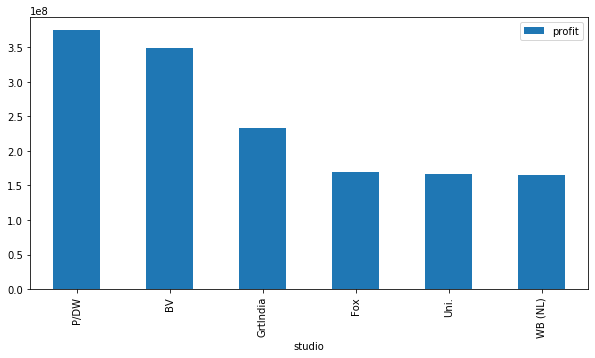

In [184]:
imdb_df4[['profit', 'studio']].groupby(['studio']).mean().sort_values(by=['profit'], ascending=False).head(6).plot.bar(figsize=(10,5))

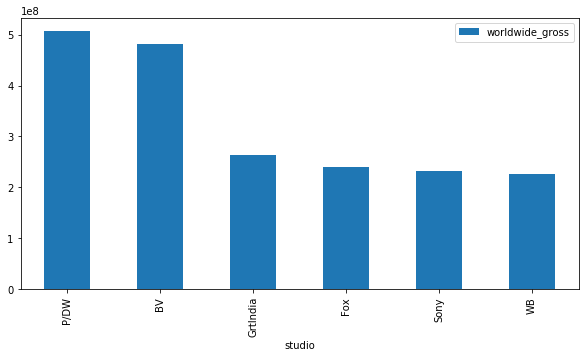

In [185]:
imdb_df4[['worldwide_gross', 'studio']].groupby(['studio']).mean().sort_values(by=['worldwide_gross'], ascending=False).head(6).plot.bar(figsize=(10,5))

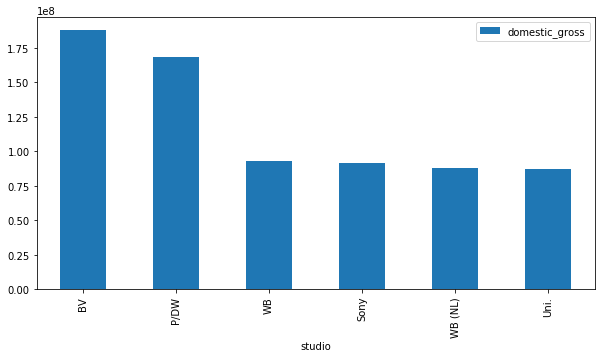

In [186]:
imdb_df4[['domestic_gross', 'studio']].groupby(['studio']).mean().sort_values(by=['domestic_gross'], ascending=False).head(6).plot.bar(figsize=(10,5))

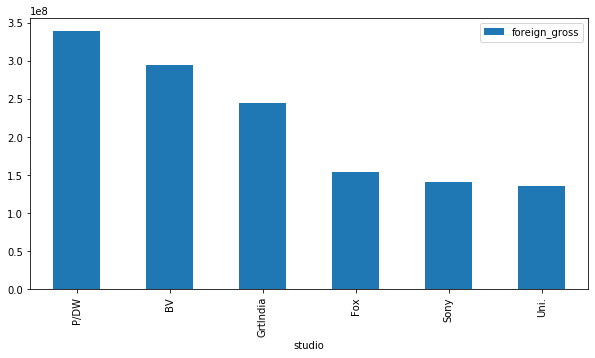

In [187]:
imdb_df4[['foreign_gross', 'studio']].groupby(['studio']).mean().sort_values(by=['foreign_gross'], ascending=False).head(6).plot.bar(figsize=(10,5))

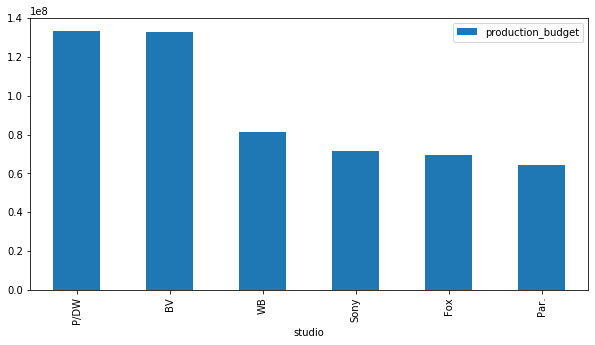

In [188]:
imdb_df4[['production_budget', 'studio']].groupby(['studio']).mean().sort_values(by=['production_budget'], ascending=False).head(6).plot.bar(figsize=(10,5))

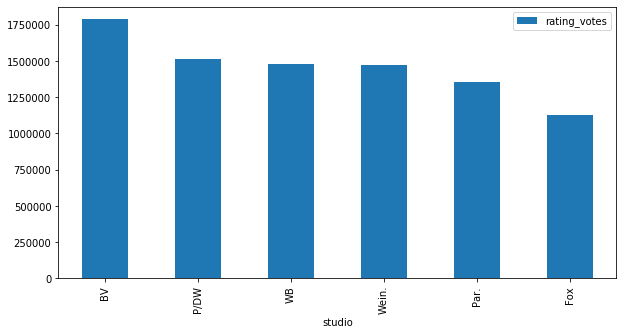

In [189]:
imdb_df4[['rating_votes', 'studio']].groupby(['studio']).mean().sort_values(by=['rating_votes'], ascending=False).head(6).plot.bar(figsize=(10,5))

In [168]:
list(imdb_df4[['worldwide_gross', 'studio']].groupby(['studio']).mean().sort_values(by=['worldwide_gross'], ascending=False).head(6).index)

['P/DW',
 'BV',
 'GrtIndia',
 'Fox',
 'Sony',
 'WB',
 'Uni.',
 'WB (NL)',
 'Par.',
 'Sum.']

In [169]:
top_studios = ['P/DW','BV','Fox','WB']

In [192]:
[print(x.lower()) for x in top_studios]

p/dw
bv
fox
wb


[None, None, None, None]

In [171]:
top_studios_df = imdb_df4.loc[imdb_df4.studio.isin(top_studios)]

In [174]:
top_studios_df.studio.value_counts()

Fox     121
WB      118
BV       82
P/DW     10
Name: studio, dtype: int64

In [180]:
top_studios_df.loc[top_studios_df.studio == 'BV'].sort_values(by='worldwide_gross', ascending = False)

primary_title  runtime_minutes  \
tconst                                                                          
tt4154756                             Avengers: Infinity War            149.0   
tt2395427                            Avengers: Age of Ultron            141.0   
tt1825683                                      Black Panther            134.0   
tt2294629                                             Frozen            102.0   
tt2771200                               Beauty and the Beast            129.0   
tt3606756                                      Incredibles 2            118.0   
tt1300854                                         Iron Man 3            130.0   
tt3498820                         Captain America: Civil War            147.0   
tt0435761                                        Toy Story 3            103.0   
tt3748528                       Rogue One: A Star Wars Story            133.0   
tt1298650        Pirates of the Caribbean: On Stranger Tides            136.0   
tt1014759                                Alice in Wonderland            108.0   
tt2277860                                       Finding Dory             97.0   
tt2948356                                           Zootopia            108.0   
tt3040964                                    The Jungle Book            106.0   
tt3896198                     Guardians of the Galaxy Vol. 2            136.0   
tt2096673                                         Inside Out             95.0   
tt3501632                                     Thor: Ragnarok            130.0   
tt2380307                                               Coco            105.0   
tt1790809   Pirates of the Caribbean: Dead Men Tell No Tales            129.0   
tt2015381                            Guardians of the Galaxy            121.0   
tt1587310                                         Maleficent             97.0   
tt1453405                                Monsters University            104.0   
tt1843866                Captain America: The Winter Soldier            136.0   
tt1211837                                     Doctor Strange            115.0   
tt2245084                                         Big Hero 6            102.0   
tt1981115                               Thor: The Dark World            112.0   
tt3521164                                              Moana            107.0   
tt5095030                               Ant-Man and the Wasp            118.0   
tt0398286                                            Tangled            100.0   
tt1216475                                             Cars 2            106.0   
tt1217209                                              Brave             93.0   
tt1661199                                         Cinderella            105.0   
tt5848272                          Ralph Breaks the Internet            112.0   
tt0478970                                            Ant-Man            117.0   
tt1772341                                     Wreck-It Ralph            101.0   
tt1623205                          Oz the Great and Powerful            130.0   
tt1104001                                       TRON: Legacy            125.0   
tt3778644                            Solo: A Star Wars Story            135.0   
tt3606752                                             Cars 3            102.0   
tt5028340                               Mary Poppins Returns            130.0   
tt1979388                                  The Good Dinosaur             93.0   
tt0401729                                        John Carter            132.0   
tt2567026                    Alice Through the Looking Glass            113.0   
tt0443272                                            Lincoln            150.0   
tt0433035                                         Real Steel            127.0   
tt1210819                                    The Lone Ranger            150.0   
tt0963966                          The Sorcerer's Apprentice            109.0 

In [181]:
top_studios_df.loc[top_studios_df.studio == 'P/DW'].sort_values(by='worldwide_gross', ascending = False)

primary_title  runtime_minutes  \
tconst                                                           
tt1399103      Transformers: Dark of the Moon            154.0   
tt0892791                 Shrek Forever After             93.0   
tt1277953  Madagascar 3: Europe's Most Wanted             93.0   
tt1302011                     Kung Fu Panda 2             90.0   
tt0448694                       Puss in Boots             90.0   
tt0892769            How to Train Your Dragon             98.0   
tt1001526                            Megamind             95.0   
tt1446192               Rise of the Guardians             97.0   
tt0427152                 Dinner for Schmucks            114.0   
tt0763831                    A Thousand Words             91.0   

                                   genres  average_rating  num_votes  \
tconst                                                                 
tt1399103     [Action, Adventure, Sci-Fi]             6.2   366409.0   
tt0892791  [Adventure, Animation, Comedy]             6.3   167532.0   
tt1277953  [Adventure, Animation, Comedy]             6.8   146858.0   
tt1302011  [Action, Adventure, Animation]             7.2   228465.0   
tt0448694  [Action, Adventure, Animation]             6.6   133355.0   
tt0892769  [Action, Adventure, Animation]             8.1   611299.0   
tt1001526     [Action, Animation, Comedy]             7.3   207488.0   
tt1446192  [Action, Adventure, Animation]             7.3   145281.0   
tt0427152                        [Comedy]             5.9    91546.0   
tt0763831                 [Comedy, Drama]             5.9    36387.0   

                               directors  \
tconst                                     
tt1399103                      nm0000881   
tt0892791                      nm0593610   
tt1277953  nm0569891,nm0970447,nm0201509   
tt1302011                      nm0950775   
tt0448694                      nm3735491   
tt0892769            nm0761498,nm0213450   
tt1001526                      nm0569891   
tt1446192                      nm0709056   
tt0427152                      nm0005366   
tt0763831                      nm0005367   

                                                     writers studio  year  \
tconst                                                                      
tt1399103                                          nm0472567   P/DW  2011   
tt0892791  nm0825308,nm0458441,nm0501359,nm0011470,nm0254...   P/DW  2010   
tt1277953  nm0201509,nm0000876,nm0123666,nm0405190,nm0569...   P/DW  2012   
tt1302011            nm0008743,nm0074184,nm0717550,nm0903456   P/DW  2011   
tt0448694  nm1117226,nm0528244,nm0204030,nm0011470,nm0674...   P/DW  2011   
tt0892769  nm0204030,nm0213450,nm0761498,nm2441763,nm0405...   P/DW  2010   
tt1001526                                nm0774786,nm2523794   P/DW  2010   
tt1446192                                nm1865755,nm0431622   P/DW  2012   
tt0427152                      nm1115862,nm1911349,nm0891554   P/DW  2010   
tt0763831                                          nm0466175   P/DW  2012   

          release_date  ...  musical  mystery  romance  sci_fi  sport  \
tconst                  ...                                             
tt1399103   2011-06-29  ...    False    False    False    True  False   
tt0892791   2010-05-21  ...    False    False    False   False  False   
tt1277953   2012-06-08  ...    False    False    False   False  False   
tt1302011   2011-05-26  ...    False    False    False   False  False   
tt0448694   2011-10-28  ...    False    False    False   False  False   
tt0892769   2010-03-26  ...    False    False    False   False  False   
tt1001526   2010-11-05  ...    False    False    False   False  False   
tt1446192   2012-11-21  ...    False    False    False   False  False   
tt0427152   2010-07-30  ...    False    False    False   False  False   
tt0763831   2012-03-09  ...    False    False    False   False  False   

           thriller    war  western  rating

In [183]:
top_studios_df.loc[top_studios_df.studio == 'WB'].sort_values(by='worldwide_gross', ascending = False)

primary_title  runtime_minutes  \
tconst                                                                      
tt1477834                                        Aquaman            143.0   
tt1345836                          The Dark Knight Rises            164.0   
tt2975590             Batman v Superman: Dawn of Justice            151.0   
tt1375666                                      Inception            148.0   
tt0451279                                   Wonder Woman            141.0   
tt3183660        Fantastic Beasts and Where to Find Them            132.0   
tt1386697                                  Suicide Squad            123.0   
tt1454468                                        Gravity             91.0   
tt0770828                                   Man of Steel            143.0   
tt0974015                                 Justice League            120.0   
tt4123430    Fantastic Beasts: The Crimes of Grindelwald            134.0   
tt1411697                           The Hangover Part II            102.0   
tt1677720                               Ready Player One            140.0   
tt3731562                             Kong: Skull Island            118.0   
tt2179136                                American Sniper            133.0   
tt1515091             Sherlock Holmes: A Game of Shadows            129.0   
tt4779682                                        The Meg            113.0   
tt0831387                                       Godzilla            123.0   
tt5013056                                        Dunkirk            106.0   
tt0800320                            Clash of the Titans            106.0   
tt1490017                                 The Lego Movie            100.0   
tt1517451                                 A Star Is Born            136.0   
tt1663662                                    Pacific Rim            131.0   
tt1631867                               Edge of Tomorrow            113.0   
tt1392190                             Mad Max: Fury Road            120.0   
tt1343092                               The Great Gatsby            143.0   
tt0918940                           The Legend of Tarzan            110.0   
tt1253863                         300: Rise of an Empire            102.0   
tt4116284                          The Lego Batman Movie            104.0   
tt1646987                            Wrath of the Titans             99.0   
tt1365519                                    Tomb Raider            119.0   
tt1856101                              Blade Runner 2049            164.0   
tt3263904                                          Sully             96.0   
tt1077368                                   Dark Shadows            113.0   
tt3104988                              Crazy Rich Asians            120.0   
tt1024648                                           Argo            120.0   
tt1981128                                       Geostorm            109.0   
tt1133985                                  Green Lantern            114.0   
tt6182908                                      Smallfoot             96.0   
tt1231583                                       Due Date             95.0   
tt1302067                                      Yogi Bear             80.0   
tt2361509                                     The Intern            121.0   
tt4624424                                         Storks             87.0   
tt1617661                              Jupiter Ascending            127.0   
tt7959026                                       The Mule            116.0   
tt1915581                                     Magic Mike            110.0   
tt2381941                                          Focus            105.0   
tt1037705                                The Book of Eli            118.0   
tt1402488                                 Happy Feet Two            100.0   
tt2140479                                 The Accountant            128.0   
tt0840361                              

In [182]:
top_studios_df.loc[top_studios_df.studio == 'Fox'].sort_values(by='worldwide_gross', ascending = False)

primary_title  runtime_minutes  \
tconst                                                                          
tt1727824                                  Bohemian Rhapsody            134.0   
tt1667889                         Ice Age: Continental Drift             88.0   
tt1431045                                           Deadpool            108.0   
tt5463162                                         Deadpool 2            119.0   
tt1877832                         X-Men: Days of Future Past            132.0   
tt2103281                     Dawn of the Planet of the Apes            130.0   
tt3659388                                        The Martian            144.0   
tt0454876                                         Life of Pi            127.0   
tt3315342                                              Logan            137.0   
tt1646971                         How to Train Your Dragon 2            102.0   
tt0481499                                         The Croods             98.0   
tt3385516                                  X-Men: Apocalypse            144.0   
tt1663202                                       The Revenant            156.0   
tt2267968                                    Kung Fu Panda 3             95.0   
tt3874544                                      The Boss Baby             97.0   
tt2357291                                              Rio 2            101.0   
tt3450958                     War for the Planet of the Apes            140.0   
tt1436562                                                Rio             96.0   
tt1318514                     Rise of the Planet of the Apes            105.0   
tt0980970  The Chronicles of Narnia: The Voyage of the Da...            113.0   
tt1430132                                      The Wolverine            126.0   
tt4649466                        Kingsman: The Golden Circle            141.0   
tt1446714                                         Prometheus            124.0   
tt3416828                          Ice Age: Collision Course             94.0   
tt1485796                               The Greatest Showman            105.0   
tt2224026                                               Home             94.0   
tt1628841                       Independence Day: Resurgence            120.0   
tt1397280                                            Taken 2             92.0   
tt2267998                                          Gone Girl            149.0   
tt1911658                             Penguins of Madagascar             92.0   
tt1270798                                 X-Men: First Class            131.0   
tt2692250            Night at the Museum: Secret of the Tomb             98.0   
tt1615918               Alvin and the Chipmunks: Chipwrecked             87.0   
tt1790864                                    The Maze Runner            113.0   
tt3402236                       Murder on the Orient Express            114.0   
tt1679335                                             Trolls             92.0   
tt4046784                     Maze Runner: The Scorch Trials            131.0   
tt2582846                             The Fault in Our Stars            126.0   
tt1606378                             A Good Day to Die Hard             98.0   
tt1935859        Miss Peregrine's Home for Peculiar Children            127.0   
tt3411444                                          Ferdinand            108.0   
tt1860353                                              Turbo             96.0   
tt0864835                              Mr. Peabody & Sherman             92.0   
tt1528100                             Exodus: Gods and Kings            150.0   
tt4500922                                     The Death Cure            143.0   
tt0848537                                               Epic            102.0   
tt2452042                                  The Peanuts Movie             88.0   
tt2974918             Alvin and the Chipmunks: The Road Chip             92.0 

In [137]:
imdb_df4.groupby(['studio']).size().sort_values()

studio
3D               1
Jan.             1
IM               1
Hiber            1
GrtIndia         1
Global Road      1
Neon             1
Orch.            1
P4               1
PH               1
EOne             1
ENTMP            1
ELS              1
KE               1
Cleopatra        1
Drft.            1
LD               1
RLJ              1
Viv.             1
Relbig.          1
ATO              1
BSC              1
SMod             1
Saban            1
Aviron           1
App.             1
ParV             1
VE               1
Alc              1
LGP              2
Affirm           2
CE               2
Amazon           2
Mira.            2
Cohen            2
Studio 8         2
Over.            3
PNT              3
MGM              3
Yash             3
EC               3
Anch.            3
RTWC             4
BH Tilt          4
Annapurna        4
UTV              4
PFR              4
Eros             4
W/Dim.           4
BG               5
Free             5
Gold.            5
BST  

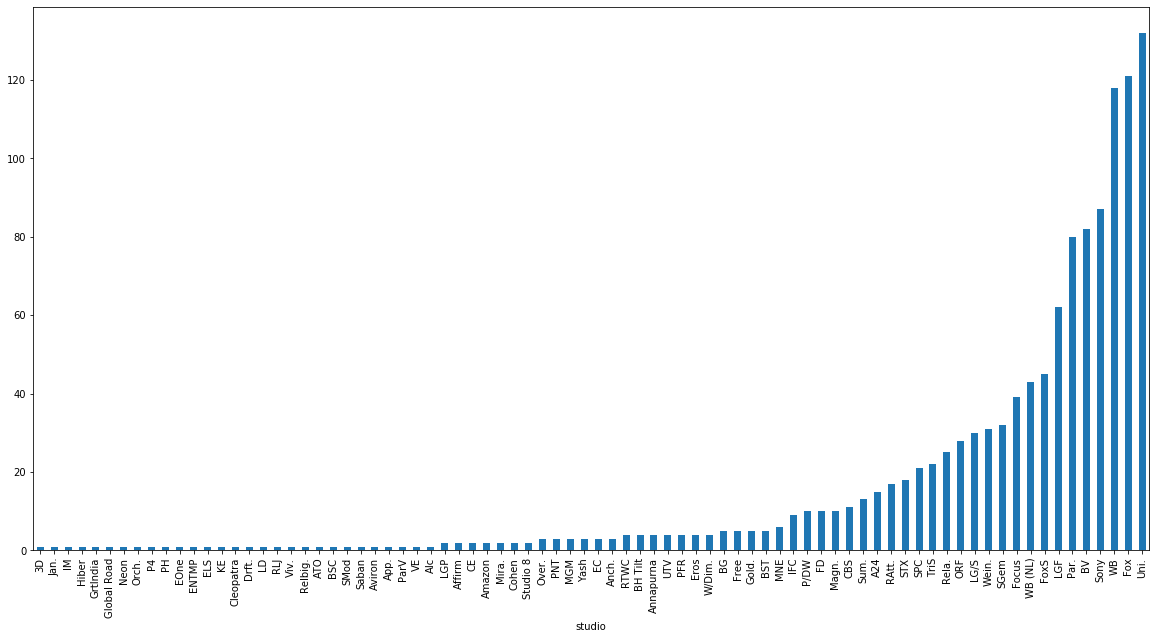

In [134]:
imdb_df4.groupby(['studio']).size().sort_values().plot.bar(figsize=(20,10))

In [128]:
imdb_df4.studio.unique().sort()

In [126]:
imdb_df4.groupby(['studio']).get_group('BV')

primary_title  runtime_minutes  \
tconst                                                           
tt0398286                             Tangled            100.0   
tt0401729                         John Carter            132.0   
tt0433035                          Real Steel            127.0   
tt0435761                         Toy Story 3            103.0   
tt0443272                             Lincoln            150.0   
...                                       ...              ...   
tt4341582                      Queen of Katwe            124.0   
tt5028340                Mary Poppins Returns            130.0   
tt5095030                Ant-Man and the Wasp            118.0   
tt5523010  The Nutcracker and the Four Realms             99.0   
tt5848272           Ralph Breaks the Internet            112.0   

                                   genres  average_rating  num_votes  \
tconst                                                                 
tt0398286  [Adventure, Animation, Comedy]             7.8   366366.0   
tt0401729     [Action, Adventure, Sci-Fi]             6.6   241792.0   
tt0433035         [Action, Drama, Family]             7.1   283534.0   
tt0435761  [Adventure, Animation, Comedy]             8.3   682218.0   
tt0443272     [Biography, Drama, History]             7.4   228701.0   
...                                   ...             ...        ...   
tt4341582       [Biography, Drama, Sport]             7.4    13039.0   
tt5028340       [Comedy, Family, Fantasy]             6.9    52103.0   
tt5095030     [Action, Adventure, Comedy]             7.1   244024.0   
tt5523010    [Adventure, Family, Fantasy]             5.5    18734.0   
tt5848272  [Adventure, Animation, Comedy]             7.1    85694.0   

                     directors  \
tconst                           
tt0398286  nm1977355,nm0397174   
tt0401729            nm0004056   
tt0433035            nm0506613   
tt0435761            nm0881279   
tt0443272            nm0000229   
...                        ...   
tt4341582            nm0619762   
tt5028340            nm0551128   
tt5095030            nm0715636   
tt5523010  nm0002120,nm0002653   
tt5848272  nm1601882,nm0601781   

                                                     writers studio  year  \
tconst                                                                      
tt0398286                      nm1557594,nm0342278,nm0342303     BV  2010   
tt0401729            nm0004056,nm0028764,nm0149290,nm0123194     BV  2012   
tt0433035            nm0309691,nm0319659,nm0505230,nm0558577     BV  2011   
tt0435761            nm0005124,nm0004056,nm0881279,nm1578335     BV  2010   
tt0443272                                nm1065785,nm0329447     BV  2012   
...                                                      ...    ...   ...   
tt4341582                                nm0923980,nm1885371     BV  2016   
tt5028340            nm0871308,nm1341735,nm0551128,nm0217896     BV  2018   
tt5095030  nm0571344,nm1273099,nm0748620,nm3029372,nm2592...     BV  2018   
tt5523010                      nm2060755,nm0006782,nm0677535     BV  2018   
tt5848272  nm1601882,nm0962596,nm0601781,nm0714114,nm2888...     BV  2018   

          release_date  ...  horror  music  musical  mystery  romance  sci_fi  \
tconst                  ...                                                     
tt0398286   2010-11-24  ...   False  False    False    False    False   False   
tt0401729   2012-03-09  ...   False  False    False    False    False    True   
tt0433035   2011-10-07  ...   False  False    False    False    False   False   
tt0435761   2010-06-18  ...   False  False    False    False    False   False   
tt0443272   2012-11-09  ...   False  False    False    False    False   False   
...                ...  ...     ...    ...      ...      ...      ...     ...   
tt4341582   2016-09-23  ...   False  False    False    False    False   False   
tt5028340   2018-12-19  ...   False  False    False    False  